**2277007 김수진 2277xxx OOO**

# 1. Libraries Import

In [17]:
import re
import requests
from requests import get
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from fake_useragent import UserAgent
import os

print("import completed")

import completed


# 2. Crawling

https://developer-ankiwoong.tistory.com/843

### Crawling Titles, Directors, and Genres (정적데이터)

(다른 팀원이 작성한 부분이라 삭제하였습니다)

### Crawling Stories (정적, 동적 데이터)

Story에 웹사이트의 Storyline만 넣으니 데이터가 너무 작아 군집화가 제대로 되지 않아 summary와 synopsis까지 story에 다 넣어주었다.

In [22]:
movie_ids=[]
for i in range(5):
    if i==0:
        URL = 'https://www.imdb.com/list/ls050782187/'
    else:
        URL = 'https://www.imdb.com/list/ls050782187/?sort=list_order,asc&st_dt=&mode=detail&page='+str(i+1)
    r = requests.get(URL)
    soup = BeautifulSoup(r.content, "lxml")
    entries=soup.findAll('div', class_="ribbonize")
    for a in entries:
        movie_ids.append(a['data-tconst'])
print(movie_ids[:10])

['tt0068646', 'tt0102926', 'tt0080684', 'tt0111161', 'tt0081505', 'tt0034583', 'tt0073486', 'tt0082971', 'tt0167260', 'tt0076759']


In [25]:
len(movie_ids)

500

각 영화의 세부 페이지 주소 url에서 바뀌는 부분을 추출했다. id가 총 500개이므로 정상적으로 크롤링된 것을 확인할 수 있다.

In [17]:
from selenium import webdriver
import time
from tqdm import tqdm

Stories = []
driver = webdriver.Chrome()
for id_ in tqdm(movie_ids):
    url = "https://www.imdb.com/title/"+id_+"/?ref_=ttls_li_tt"
    driver.get(url)
    time.sleep(10)
    data = driver.page_source
    s = BeautifulSoup(data,"html.parser")
    story = s.findAll("div", {'class':"ipc-html-content-inner-div"})
    Stories.append(story[1].text)
driver.close()
Stories[3]

100%|██████████| 500/500 [1:53:31<00:00, 13.62s/it]


"Chronicles the experiences of a formerly successful banker as a prisoner in the gloomy jailhouse of Shawshank after being found guilty of a crime he did not commit. The film portrays the man's unique way of dealing with his new, torturous life; along the way he befriends a number of fellow prisoners, most notably a wise long-term inmate named Red. —J-S-Golden"

In [28]:
i=0
for id_ in tqdm(movie_ids):
    s = []
    url = 'https://www.imdb.com/title/'+str(id_)+'/plotsummary?ref_=tt_stry_pl#synopsis'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    entries=soup.find_all('li', class_='ipl-zebra-list__item')
    for a in entries:
        s.append(a.text)
    s = ' '.join(s)
    Stories[i] = Stories[i] + ' // ' + s
    i+=1

100%|██████████| 500/500 [09:02<00:00,  1.09s/it]


In [32]:
Stories[3][:500]

"Chronicles the experiences of a formerly successful banker as a prisoner in the gloomy jailhouse of Shawshank after being found guilty of a crime he did not commit. The film portrays the man's unique way of dealing with his new, torturous life; along the way he befriends a number of fellow prisoners, most notably a wise long-term inmate named Red. —J-S-Golden  // \nTwo imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.\n \nChronicles t"

In [18]:
len(Stories)

500

총 500개의 영화 데이터가 정상적으로 크롤링된 것을 확인할 수 있다.

### Create DataFrame and Convert It to CSV

한 번 크롤링할 때마다 2시간 반 정도가 소요되므로 데이터를 csv 파일로 저장한다.

In [27]:
df = pd.DataFrame({'title': titles, 
                   'director':Directors, 
                   'genre':Genres, 
                   'story': Stories})

In [28]:
df.to_csv("./movie.csv")

Step2에서 이미지 파일을 다운받기 위해 id와 title이 들어간 DataFrame도 만들어 준다.

In [29]:
id_df = pd.DataFrame({'id': movie_ids, 'title': titles })

In [31]:
id_df.to_csv("./id.csv")

## 추가: storyline crawling 오류 해결(동적 데이터)

https://moneynlifehacker.com/10%EB%B6%84%EB%A7%8C-%ED%95%B4%EB%B3%B4%EC%84%B8%EC%9A%94-%EB%8F%99%EC%A0%81-%EC%9B%B9-%ED%8E%98%EC%9D%B4%EC%A7%80-%ED%81%AC%EB%A1%A4%EB%A7%81-selenium/

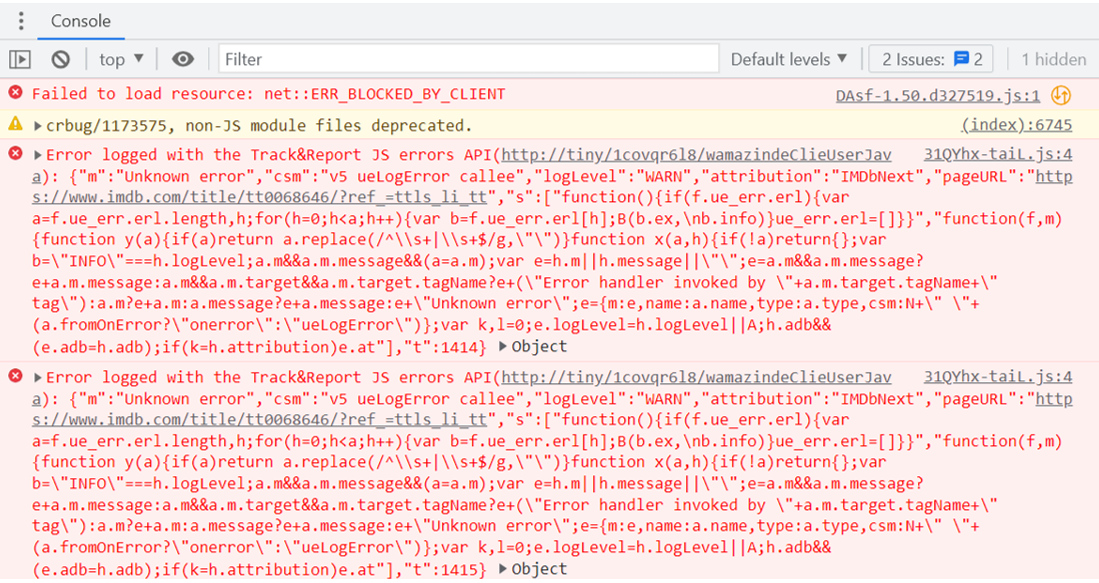

맞게 크롤링을 해도 계속 None이 떠서 콘솔을 확인해보았는데 온통 에러 메시지가 떴었다.

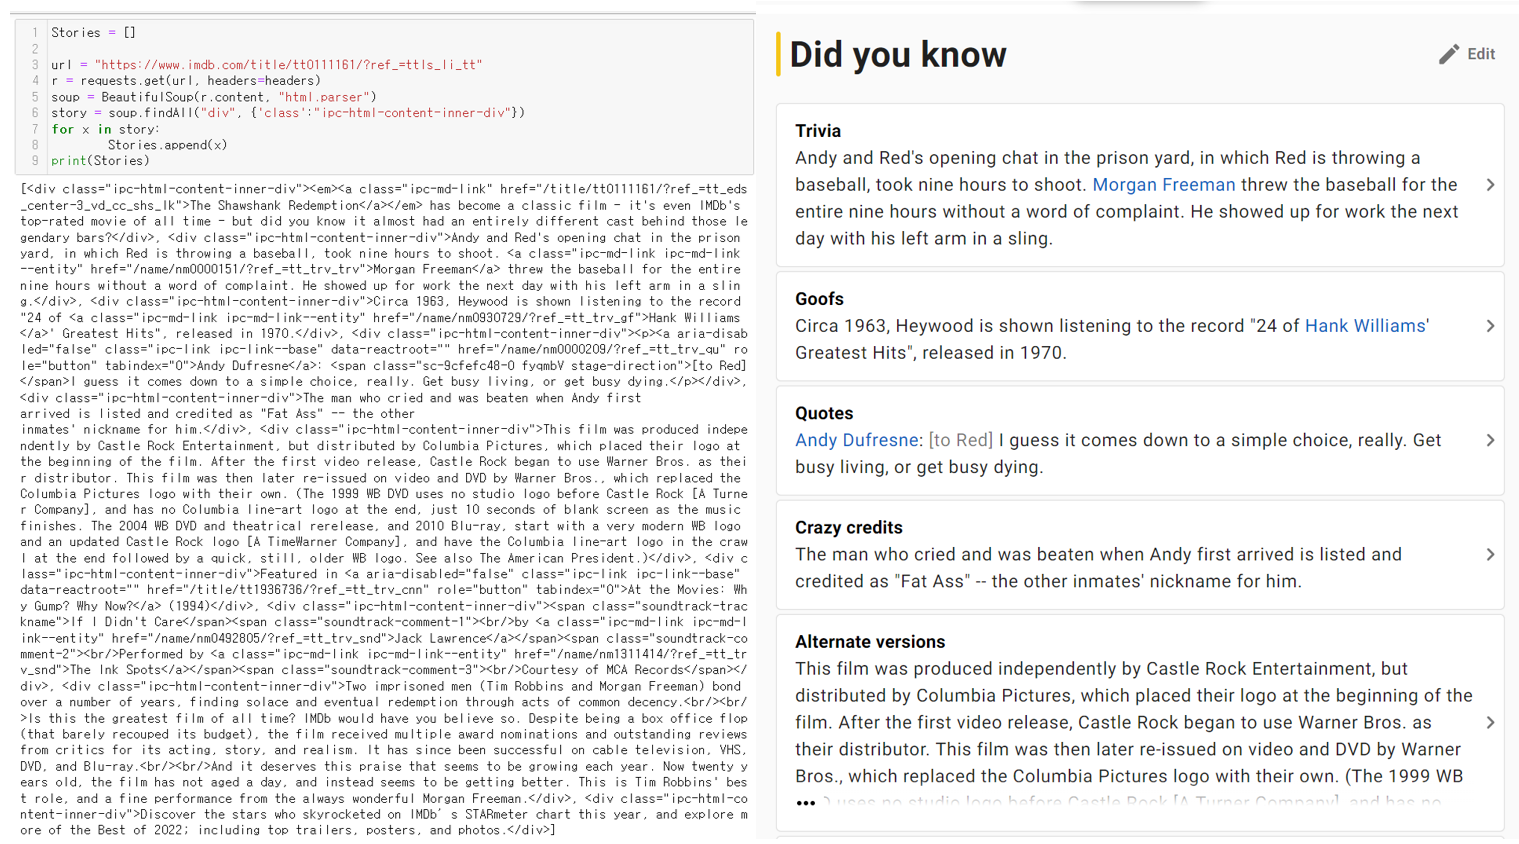

* (왼쪽) 정적 크롤링 방식
* (오른쪽) 정적 크롤링 방식으로 크롤링하였을 때 웹페이지에서 읽히는 부분

soup을 확인해보아도 내가 원하는 부분(storyline)은 전혀 없었다. 여러 크롬 확장 프로그램을 제거해도 문제는 그대로였다. user agent 문제인가 하여 header를 수정해보아도 해결되지 않았다.
그러다 https://blog.naver.com/PostView.naver?blogId=mdown&logNo=222102495356&parentCategoryNo=&categoryNo=16&viewDate=&isShowPopularPosts=false&from=postView 를 발견하였다. 그리고 내가 크롤링하고 싶은 부분이 동적 데이터여서 안 읽히는 걸 깨달았다.